*Tên đề tài: Nhận diện biển báo giao thông Việt Nam*

*Người thực hiện: Ngô Văn Hữu Luân*

*StID: 19146352*

*Data: https://drive.google.com/file/d/1bf3IReAOotdSaV4ry0P7DVNcU9-UXH-W/view?usp=sharing*

In [1]:
# mount with google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
!unzip -q /content/gdrive/MyDrive/ColabNotebooks/v5Copy.zip -d /content/gdrive/MyDrive/ColabNotebooks/Data

*Import thư viện*

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
import os
import matplotlib.pyplot as plt


from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.optimizers import SGD,RMSprop,Adam

*Mount với đường dẫn đến thư mục ảnh trong drive*

In [5]:
# set data path
dataset_path = '/content/gdrive/MyDrive/ColabNotebooks/Data'

*Tạo biến lưu nhãn của biển báo*

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'Cam vuot', 
            10:'Cam do xe', 
            11:'Duong giao nhau', 
            12:'Cam di thang', 
            13:'Giao duong uu tien', 
            14:'Stop', 
            15:'Duong cam', 
            16:'Toi da 3,5t', 
            17:'Duong 1 chieu', 
            18:'Nguy hiem khac', 
            19:'Toi da 1,5t', 
            20:'Toi da 5km/h', 
            21:'Duong gap khuc', 
            22:'Vong xuyen', 
            23:'Duong tron truot', 
            24:'Duong 2 chieu hep phai', 
            25:'Cong truong', 
            26:'Cam xe khach va tai', 
            27:'Nguoi di bo', 
            28:'Truong hoc', 
            29:'Nguoi di xe dap', 
            30:'Dien cao the',
            31:'Re phai ', 
            32:'Re trai', 
            33:'Di thang', 
            34:'Di thang hoac re phai', 
            35:'Di thang hoac re trai', 
            36:'Di ben phai', 
            37:'Di ben trai' }


*Thống kê datasets*

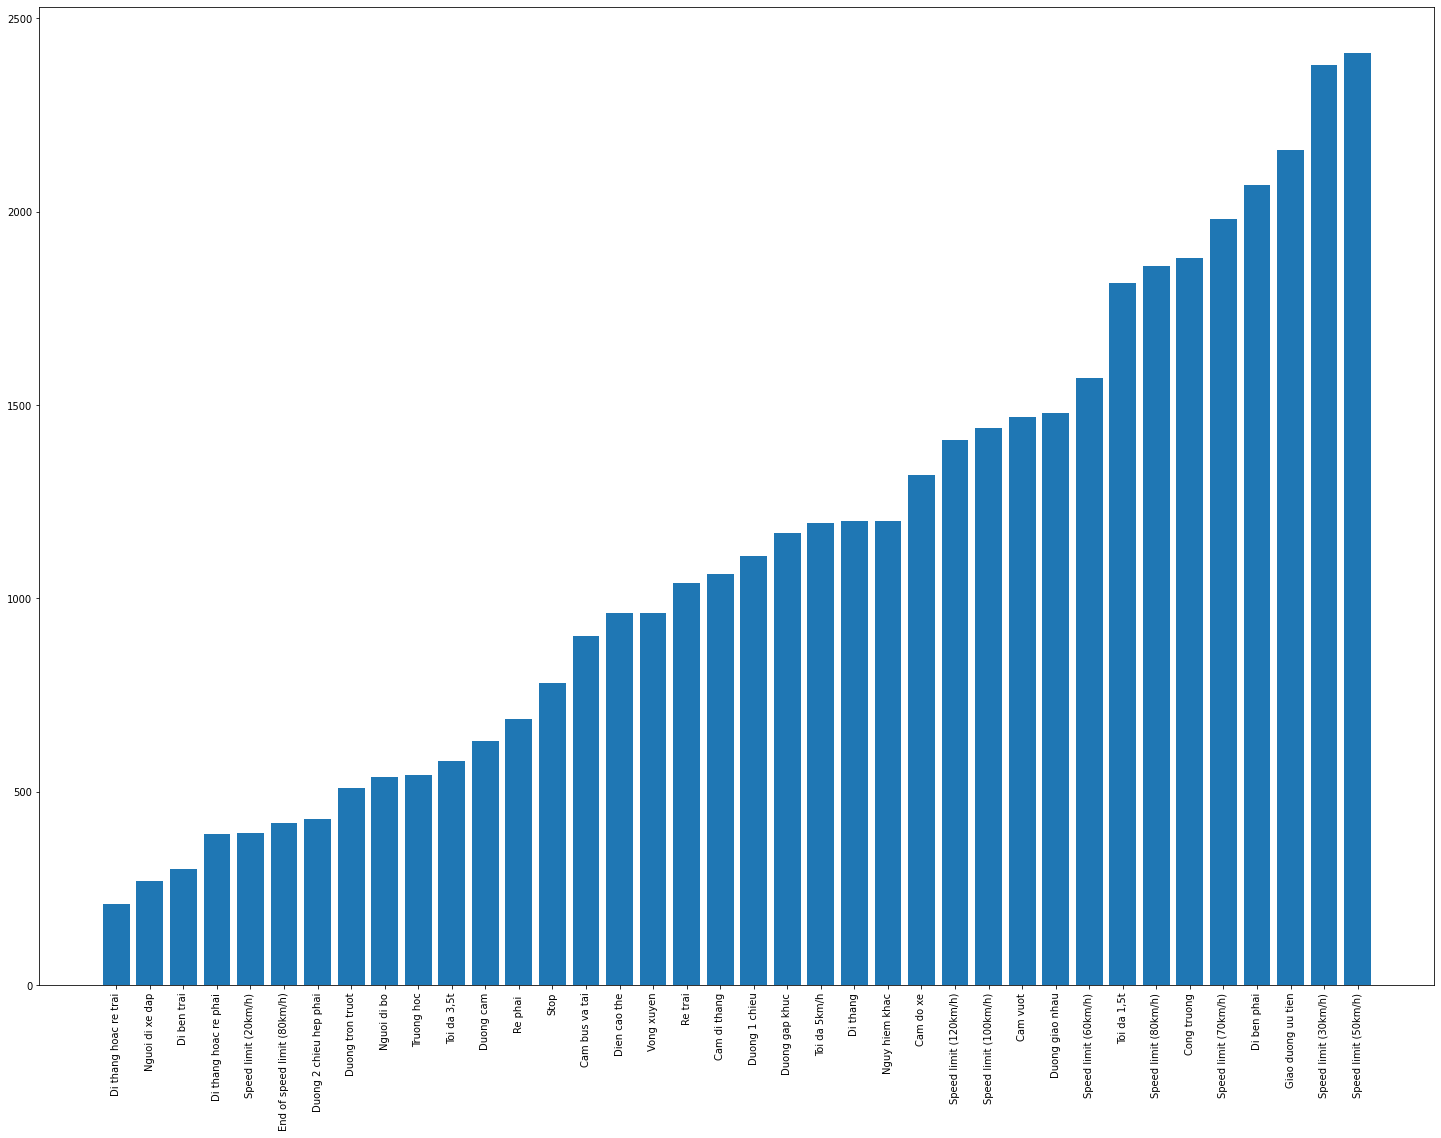

In [ ]:
folders = os.listdir(dataset_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(dataset_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sắp xếp lại tập dữ liệu theo số lượng hình ảnh trong mỗi classes
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Vẽ biểu đồ
plt.figure(figsize=(25,18))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

*Chia dữ liệu cho train và validation*

In [6]:
image_size = (30,30)
TRAINING_DATA_DIR = str(dataset_path)
print(TRAINING_DATA_DIR)

# modify data
kwargs_datagen = dict(rescale=1./255, validation_split=0.2) # 20 phần trăm cho validation

# validation data modify 
valid_datagen = ImageDataGenerator(**kwargs_datagen)
valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="validation", 
                                                    shuffle=True, target_size=image_size)

# train data modify
train_datagen = ImageDataGenerator(**kwargs_datagen)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="training",
                                                    shuffle=True,target_size=image_size)


/content/gdrive/MyDrive/ColabNotebooks/Data
Found 7378 images belonging to 38 classes.
Found 29534 images belonging to 38 classes.


*Sắp xếp và match labels*

In [7]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("image batch shape: ", image_batch_train.shape)
print("label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print("labels: ", dataset_labels)
print("match class: ", train_generator.class_indices)

image batch shape:  (32, 30, 30, 3)
label batch shape:  (32, 38)
labels:  ['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '31' '32' '33' '34' '35' '36' '37']
match class:  {'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37}


*Xây dựng kiến trúc CNN*

In [8]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(38, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         7

*Training model*

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(train_generator, batch_size=32, epochs=14, 
                    validation_data=valid_generator)
model.save("CNN_trafficsignFinal.h5")

Epoch 1/14
1069/1069 [==============================] - 77s 71ms/step - loss: 0.1057 - accuracy: 0.9708 - val_loss: 0.4132 - val_accuracy: 0.8833
Epoch 2/14
1069/1069 [==============================] - 76s 71ms/step - loss: 0.0467 - accuracy: 0.9864 - val_loss: 0.3773 - val_accuracy: 0.8989
Epoch 3/14
1069/1069 [==============================] - 74s 69ms/step - loss: 0.0374 - accuracy: 0.9886 - val_loss: 0.1556 - val_accuracy: 0.9568
Epoch 4/14
1069/1069 [==============================] - 75s 70ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 0.2156 - val_accuracy: 0.9500
Epoch 5/14
1069/1069 [==============================] - 73s 69ms/step - loss: 0.0282 - accuracy: 0.9921 - val_loss: 0.2107 - val_accuracy: 0.9595
Epoch 6/14
1069/1069 [==============================] - 74s 69ms/step - loss: 0.0263 - accuracy: 0.9921 - val_loss: 0.2584 - val_accuracy: 0.9529
Epoch 7/14
1069/1069 [==============================] - 73s 68ms/step - loss: 0.0225 - accuracy: 0.9937 - val_loss: 0.1460 -

*Kiểm tra, đánh giá và vẽ đồ thị*

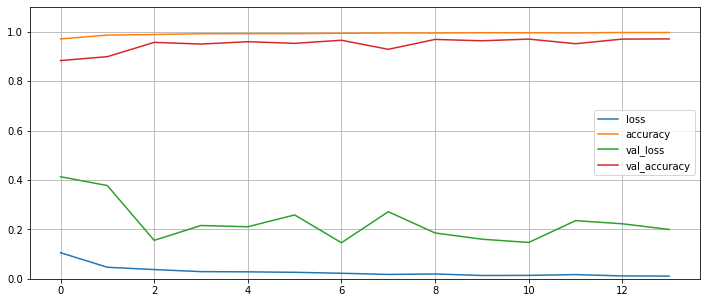

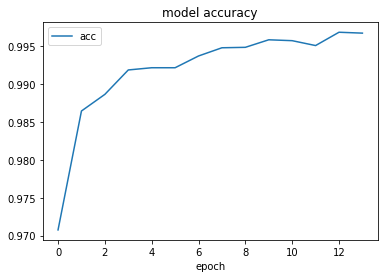

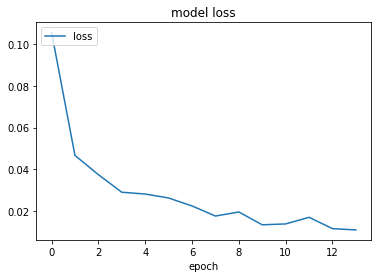

In [20]:
# Diagram
pd.DataFrame(history.history).plot(figsize = (12,5))
plt.grid(True)
plt.gca().set_ylim(0,1.1)
plt.show()

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])

plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc = 'upper left')
plt.show()

*Hiển thị một số dữ liệu test* 

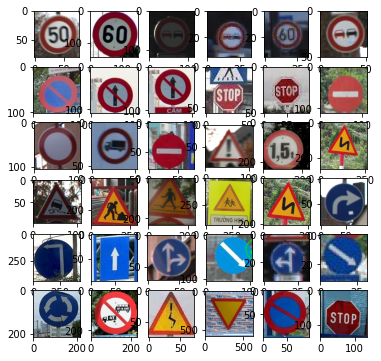

In [18]:
from matplotlib.image import imread

fig = plt.figure(figsize=(6,6))

for i in range(1,37):
  ax1 = fig.add_subplot(6,6,i)
  img = imread(str(i)+'.jpg')
  ax1.imshow(img)




*Nhận diện hình ảnh biển báo*

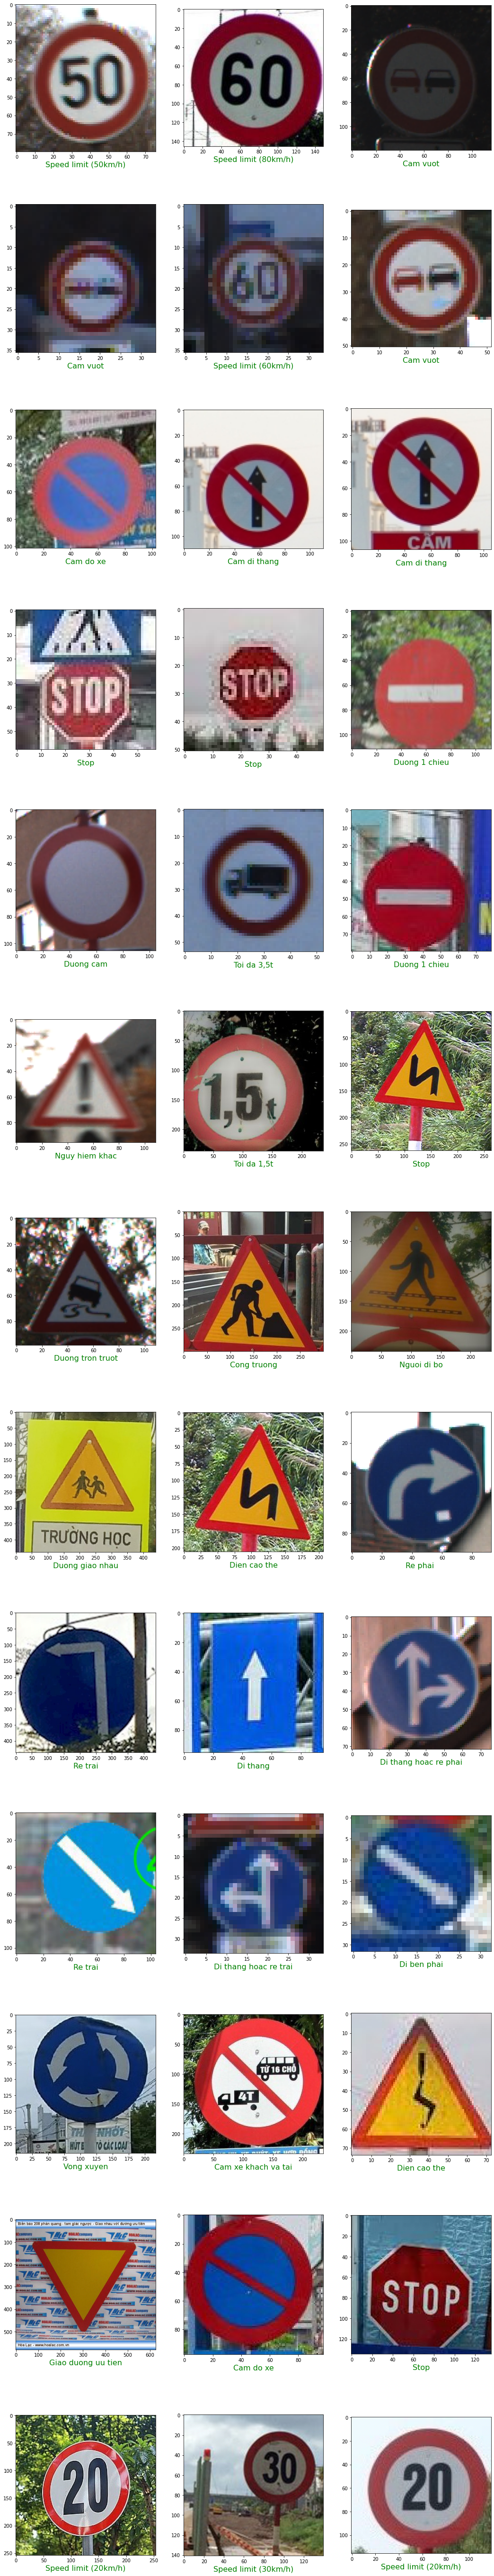

In [52]:
from matplotlib.image import imread
from tensorflow.keras import datasets,layers,models
from keras.preprocessing import image
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array 
import numpy as np

model_trafficsign = load_model('CNN_trafficsignFinal.h5')

def predict(filename):

  # Load and define image - to test

  img = load_img(f'{filename}', target_size=(30,30))
  plt.imshow(img)
  img=image.img_to_array(img) 
  img=img.reshape(1,30,30,3)
  img=img.astype('float32')
  img=img/255

  # predict 
  guess = np.argmax(model_trafficsign.predict(img),axis=1)

  kq = print(' Traffic sign is: ' , guess)
  return kq

fig = plt.figure(figsize=(18,100))

for i in range(1,40):
  ax1 = fig.add_subplot(13,3,i)
  img = imread(str(i)+'.jpg')

  img_pred = load_img(str(i)+'.jpg', target_size=(30,30))
  img_pred=image.img_to_array(img_pred) 
  img_pred=img_pred.reshape(1,30,30,3)
  img_pred=img_pred.astype('float32')
  img_pred=img_pred/255
  guess = np.argmax(model_trafficsign.predict(img_pred),axis=1)
  for j in range(0,39):
    if guess==[j]: 
      guess = j
  # print('kq la' , classes[guess])

  kq = classes[guess]

  plt.xlabel(kq, fontsize=16, color = 'g')
  ax1.imshow(img)

*Nhận diện từng biển báo*

 Traffic sign is:  Speed limit (50km/h)


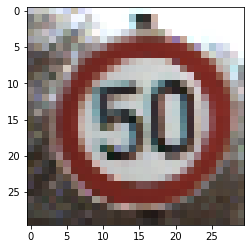

 Traffic sign is:  Speed limit (80km/h)


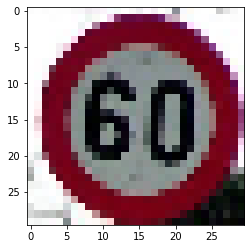

 Traffic sign is:  Cam vuot


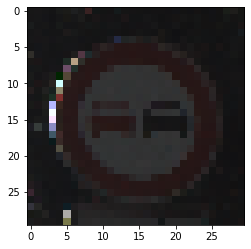

 Traffic sign is:  Cam vuot


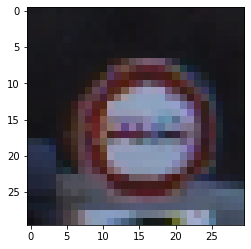

 Traffic sign is:  Speed limit (60km/h)


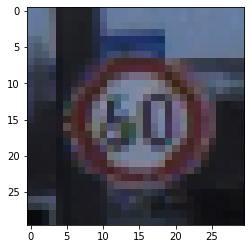

 Traffic sign is:  Cam vuot


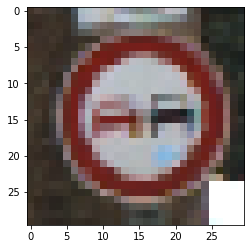

 Traffic sign is:  Cam do xe


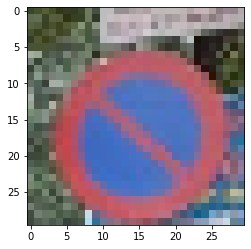

 Traffic sign is:  Cam di thang


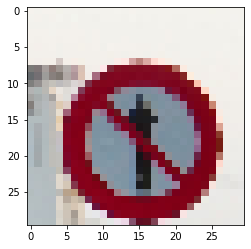

 Traffic sign is:  Cam di thang


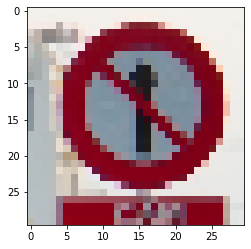

 Traffic sign is:  Stop


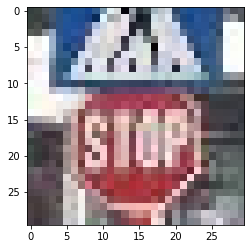

 Traffic sign is:  Stop


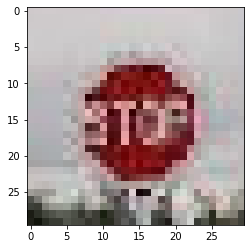

 Traffic sign is:  Duong 1 chieu


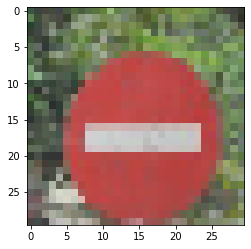

 Traffic sign is:  Duong cam


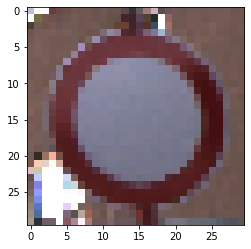

 Traffic sign is:  Toi da 3,5t


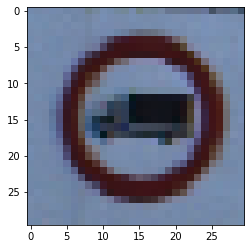

 Traffic sign is:  Duong 1 chieu


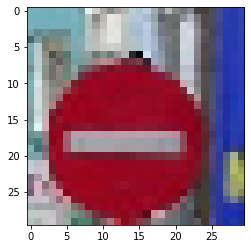

 Traffic sign is:  Nguy hiem khac


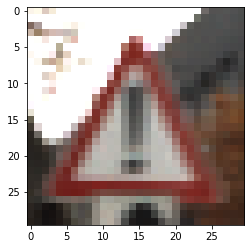

 Traffic sign is:  Toi da 1,5t


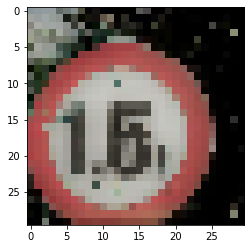

 Traffic sign is:  Stop


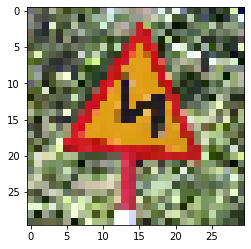

 Traffic sign is:  Duong tron truot


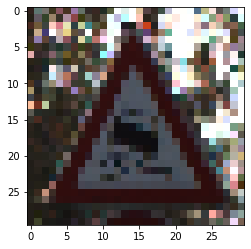

 Traffic sign is:  Cong truong


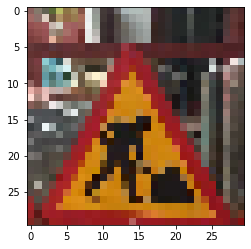

 Traffic sign is:  Nguoi di bo


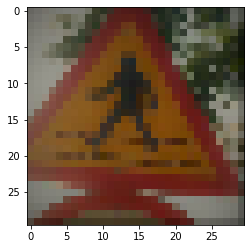

 Traffic sign is:  Duong giao nhau


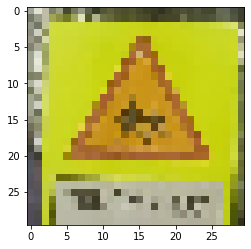

 Traffic sign is:  Dien cao the


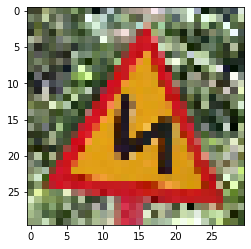

 Traffic sign is:  Re phai 


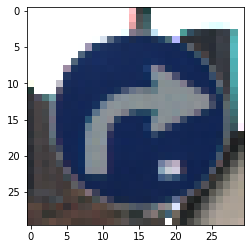

 Traffic sign is:  Re trai


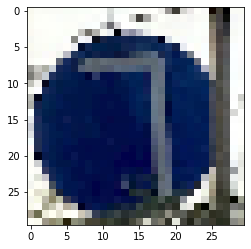

 Traffic sign is:  Di thang


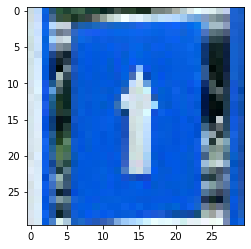

 Traffic sign is:  Di thang hoac re phai


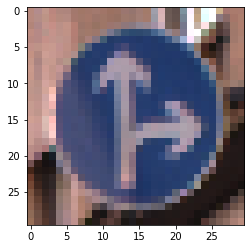

 Traffic sign is:  Re trai


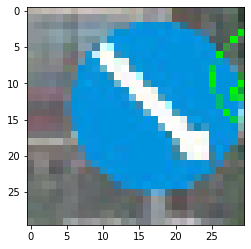

 Traffic sign is:  Di thang hoac re trai


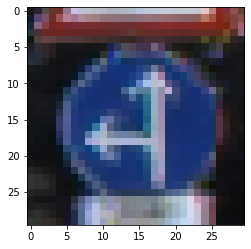

 Traffic sign is:  Di ben phai


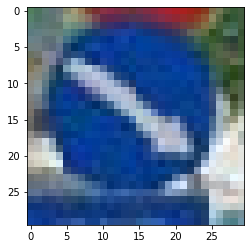

 Traffic sign is:  Vong xuyen


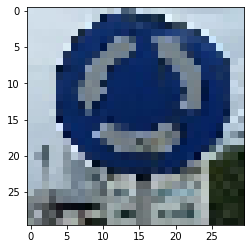

 Traffic sign is:  Cam xe khach va tai


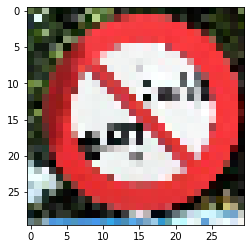

 Traffic sign is:  Dien cao the


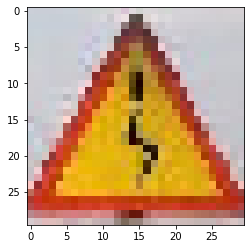

 Traffic sign is:  Giao duong uu tien


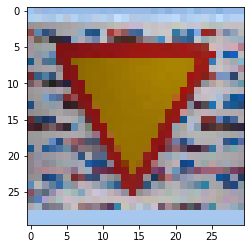

 Traffic sign is:  Cam do xe


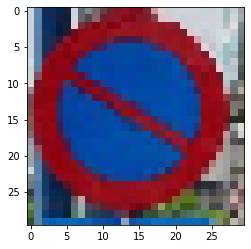

 Traffic sign is:  Stop


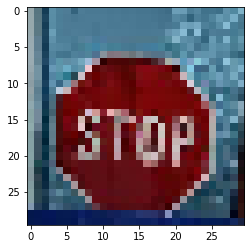

 Traffic sign is:  Speed limit (20km/h)


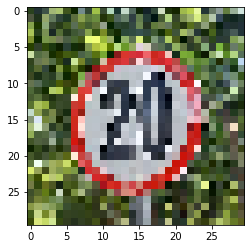

 Traffic sign is:  Speed limit (30km/h)


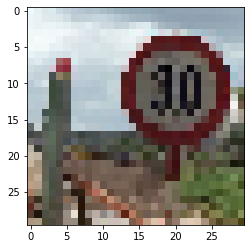

 Traffic sign is:  Speed limit (20km/h)


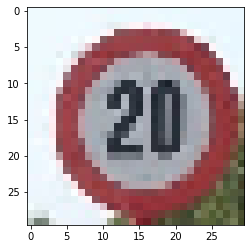

In [5]:
# Testing code with CNN model
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models
from keras.preprocessing import image
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array 
import numpy as np

model_trafficsign = load_model('CNN_trafficsignFinal.h5')

def predict(filename):

  # Load and define image - to test

  img = load_img(f'{filename}', target_size=(30,30))
  plt.imshow(img)
  img=image.img_to_array(img) 
  img=img.reshape(1,30,30,3)
  img=img.astype('float32')
  img=img/255

  # predict 
  guess = np.argmax(model_trafficsign.predict(img),axis=1)
  for i in range(0,39):
    if guess==[i]: 
      guess = i
  print(' Traffic sign is: ' , classes[guess])
  plt.show()

for name in range(1,40):
  predict(str(name)+'.jpg')

*Nhận Dạng Realtime (Run in local PC)*

In [ ]:
import numpy as np
import cv2
import pickle
from keras.models import load_model

import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models
from keras.preprocessing import image
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
#############################################

frameWidth = 300  # CAMERA RESOLUTION
frameHeight = 400
brightness = 180
threshold = 0.85  # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX
##############################################

# SETUP THE VIDEO CAMERA
cap = cv2.VideoCapture(1)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)
# IMPORT THE TRAINNED MODEL
model = load_model('CNN_trafficsignFinal.h5')


def getCalssName(classNo):
    if classNo == 0:
        return 'Speed Limit 20 km/h'
    elif classNo == 1:
        return 'Speed Limit 30 km/h'
    elif classNo == 2:
        return 'Speed Limit 50 km/h'
    elif classNo == 3:
        return 'Speed Limit 60 km/h'
    elif classNo == 4:
        return 'Speed Limit 70 km/h'
    elif classNo == 5:
        return 'Speed Limit 80 km/h'
    elif classNo == 6:
        return 'End of Speed Limit 80 km/h'
    elif classNo == 7:
        return 'Speed Limit 100 km/h'
    elif classNo == 8:
        return 'Speed Limit 120 km/h'
    elif classNo == 9:
        return 'Cam vuot'
    elif classNo == 10:
        return 'Cam do xe'
    elif classNo == 11:
        return 'Duong giao nhau'
    elif classNo == 12:
        return 'Cam di thang'
    elif classNo == 13:
        return 'Giao đưong uu tien'
    elif classNo == 14:
        return 'Stop'
    elif classNo == 15:
        return 'Duong cam'
    elif classNo == 16:
        return 'Toi da 3,5t'
    elif classNo == 17:
        return 'Duong 1 chieu'
    elif classNo == 18:
        return 'Nguy hiem khac'
    elif classNo == 19:
        return 'Toi da 1,5t'
    elif classNo == 20:
        return '5kmh'
    elif classNo == 21:
        return 'Duong gap khuc'
    elif classNo == 22:
        return 'Vong xuyen'
    elif classNo == 23:
        return 'Duong tron truot'
    elif classNo == 24:
        return 'Duong 2 chieu hep ben phai'
    elif classNo == 25:
        return 'Cong truong'
    elif classNo == 26:
        return 'Cam xe khach va xe tai'
    elif classNo == 27:
        return 'Nguoi di bo'
    elif classNo == 28:
        return 'Tre em bang qua duong'
    elif classNo == 29:
        return 'Nguoi di xe dap'
    elif classNo == 30:
        return 'Beware of ice/snow'
    elif classNo == 31:
        return 'Re phai'
    elif classNo == 32:
        return 'Re trai'
    elif classNo == 33:
        return 'Di thang'
    elif classNo == 34:
        return 'Di thang hoac re phai'
    elif classNo == 35:
        return 'Di thang hoac re trai'
    elif classNo == 36:
        return 'Di ben phai'
    elif classNo == 37:
        return 'Di ben trai'



while True:
    # READ IMAGE
    success, imgOrignal = cap.read()
    img = cv2.resize(imgOrignal, (30, 30))
    img = image.img_to_array(img)
    img = img.reshape(1, 30, 30, 3)
    img = img.astype('float32')
    img = img / 255
    # cv2.imshow("Processed Image", imgOrignal)

    # predict
    guess = np.argmax(model.predict(img), axis=1)
    classIndex = model.predict_classes(img)
    print(' Traffic sign is: ', guess)
    plt.show()

    cv2.putText(imgOrignal, "CLASS: ", (20, 35), font, 0.75, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 255, 0), 2, cv2.LINE_AA)

    probabilityValue = np.amax(guess)
    # print(probabilityValue)
    if probabilityValue > threshold:
        cv2.putText(imgOrignal, str(classIndex) + " " + str(getCalssName(classIndex)), (120, 35), font, 0.75, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(imgOrignal, str(round(probabilityValue * 10, 2)) + "%", (180, 75), font, 0.75, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.putText(imgOrignal, "No Sign", (120, 35), font, 0.75, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(imgOrignal, "No Sign", (180, 75), font, 0.75, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Processed Image", imgOrignal)

    if cv2.waitKey(40) == 27:
        break
cv2.destroyAllWindows()
cap.release()